In [1]:
#!conda install intake fsspec intake-xarray -c conda-forge -y

In [2]:
#!pip install climetlab

#!pip install climetlab_s2s_ai_challenge

In [3]:
# linting
%load_ext nb_black
%load_ext lab_black

<IPython.core.display.Javascript object>

## Calculate skill of S2S model ECMWF for daily global reforecasts

In [4]:
import climpred
import xarray as xr

<IPython.core.display.Javascript object>

### Get hindcast

S2S output is hosted on the ECMWF S3 cloud, see https://github.com/ecmwf-lab/climetlab-s2s-ai-challenge

Two ways to access:

- direct access via `intake_xarray` and integrated caching via `fsspec`
- `climetlab` with integrated caching

Resources:

- https://intake.readthedocs.io/en/latest/
- https://intake-xarray.readthedocs.io/en/latest/
- https://intake-thredds.readthedocs.io/en/latest/
- https://filesystem-spec.readthedocs.io/en/latest/
- https://climetlab.readthedocs.io/en/latest/

Hindcasts/Reforecasts are stored in `netcdf` or `grib` format.
For each initialization `init` (CF convention: `standard_name=forecast_reference_time`) in the year 2020 (see `dates`), reforecasts are available started on the same `dayofyear` from 2000-2019.

Here we get the reforecast skill for 2m temperature of forecasts initialized 2nd Jan 2000-2019.

In [5]:
dates = xr.cftime_range(start="2020-01-02", freq="7D", end="2020-12-31")

<IPython.core.display.Javascript object>

In [6]:
var = "t2m"
date = dates[0].strftime("%Y%m%d")
date

'20200102'

<IPython.core.display.Javascript object>

#### `intake_xarray`

In [7]:
import intake
import fsspec
from aiohttp import ClientSession, ClientTimeout

timeout = ClientTimeout(total=600)
fsspec.config.conf["https"] = dict(client_kwargs={"timeout": timeout})

import intake_xarray

cache_path = "my_caching_folder"
fsspec.config.conf["simplecache"] = {"cache_storage": cache_path, "same_names": True}

<IPython.core.display.Javascript object>

In [8]:
forecast = (
    intake_xarray.NetCDFSource(
        f"simplecache::https://storage.ecmwf.europeanweather.cloud/s2s-ai-challenge/data/test-input/0.3.0/netcdf/ecmwf-forecast-{var}-{date}.nc"
    )
    .to_dask()
    .compute()
)

<IPython.core.display.Javascript object>

#### `climetlab`

`climetlab` wraps `cdsapi` to download from the Copernicus Climate Data Store (CDS) and from plug-in sources:

- https://climetlab.readthedocs.io/en/latest/
- https://github.com/ecmwf-lab/climetlab-s2s-ai-challenge
- https://cds.climate.copernicus.eu/cdsapp#!/home
- https://github.com/ecmwf/cdsapi/

In [9]:
import climetlab

<IPython.core.display.Javascript object>

In [10]:
forecast_climetlab = (
    climetlab.load_dataset(
        "s2s-ai-challenge-test-input",
        origin="ecmwf",
        date=[20200102, 20200206],  # get to initializations/forecast_times
        parameter=var,
        format="netcdf",
    )
    .to_xarray()
    .compute()
)

By downloading data from this dataset, you agree to the terms and conditions defined at https://apps.ecmwf.int/datasets/data/s2s/licence/. If you do not agree with such terms, do not download the data. 


  0%|          | 0/2 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [11]:
xr.testing.assert_equal(forecast_climetlab.sel(forecast_time="2020-01"), forecast)

<IPython.core.display.Javascript object>

In [12]:
forecast_climetlab.coords

Coordinates:
  * realization    (realization) int64 0 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
  * forecast_time  (forecast_time) datetime64[ns] 2020-01-02 2020-02-06
  * lead_time      (lead_time) timedelta64[ns] 1 days 2 days ... 45 days 46 days
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
    valid_time     (forecast_time, lead_time) datetime64[ns] 2020-01-03 ... 2...

<IPython.core.display.Javascript object>

### Get observations

Choose from:

- CPC
- ERA5

#### CPC as observations
compare against CPC observations: http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.temperature/.daily/

In [13]:
cache = True
if not cache:
    chunk_dim = "T"
    grid = 1.5
    tmin = xr.open_dataset(
        f"http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.temperature/.daily/.tmin/T/(0000%201%20Jan%202020)/(0000%2001%20Apr%202020)/RANGEEDGES/X/0/{grid}/358.5/GRID/Y/90/{grid}/-90/GRID/dods",
        chunks={chunk_dim: "auto"},
    ).rename({"tmin": "t"})
    tmax = xr.open_dataset(
        f"http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.temperature/.daily/.tmax/T/(0000%201%20Jan%202020)/(0000%2001%20Apr%202020)/RANGEEDGES/X/0/{grid}/358.5/GRID/Y/90/{grid}/-90/GRID/dods",
        chunks={chunk_dim: "auto"},
    ).rename({"tmax": "t"})
    t = (tmin + tmax) / 2

    t["T"] = xr.cftime_range(start="2020-01-01", freq="1D", periods=t.T.size)

    t = t.rename({"X": "longitude", "Y": "latitude", "T": "time"})

    t["t"].attrs = tmin["t"].attrs
    t["t"].attrs["long_name"] = "Daily Temperature"
    t = t.rename({"t": "t2m"}) + 273.15
    t["t2m"].attrs["units"] = "K"
    t.to_netcdf("my_caching_folder/obs_CPC.nc")
else:
    obs = xr.open_dataset("my_caching_folder/obs_CPC.nc").compute()

<IPython.core.display.Javascript object>

#### ERA5 as observations

compare against ERA5 reanalysis fetched via https://github.com/ecmwf/cdsapi/ from https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview

In [14]:
forecast_times = forecast_climetlab.set_coords("valid_time").valid_time.values.flatten()

# takes a while, continue with obs from above
obs_era = (
    climetlab.load_source(
        "cds",
        "reanalysis-era5-single-levels",
        product_type="reanalysis",
        time=["00:00"],
        grid=[1.5, 1.5],
        param="2t",
        date=forecast_times,
    )
    .to_xarray()
    .squeeze(drop=True)
)

<IPython.core.display.Javascript object>

### Forecast verification with `climpred.HindcastEnsemble`

In [15]:
# PredictionEnsemble converts `lead_time` to `lead` due to standard_name 'forecast_period' and
#                             pd.Timedelta to `int` and set lead.attrs['units'] accordingly
forecast_climetlab.coords

Coordinates:
  * realization    (realization) int64 0 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
  * forecast_time  (forecast_time) datetime64[ns] 2020-01-02 2020-02-06
  * lead_time      (lead_time) timedelta64[ns] 1 days 2 days ... 45 days 46 days
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
    valid_time     (forecast_time, lead_time) datetime64[ns] 2020-01-03 ... 2...

<IPython.core.display.Javascript object>

In [16]:
fct = (
    climpred.HindcastEnsemble(
        forecast_climetlab.drop("valid_time").isel(lead_time=range(4))
    )
    .add_observations(obs)
    .compute()
)

metric_kwargs = dict(
    metric="rmse", comparison="e2o", alignment="same_inits", dim="init"
)

/Users/aaron.spring/Coding/climpred/climpred/checks.py:234: UserWarning: Did not find dimension "init", but renamed dimension forecast_time with CF-complying standard_name "forecast_reference_time" to init.
  warnings.warn(
/Users/aaron.spring/Coding/climpred/climpred/checks.py:234: UserWarning: Did not find dimension "member", but renamed dimension realization with CF-complying standard_name "realization" to member.
  warnings.warn(
/Users/aaron.spring/Coding/climpred/climpred/checks.py:234: UserWarning: Did not find dimension "lead", but renamed dimension lead_time with CF-complying standard_name "forecast_period" to lead.
  warnings.warn(


<IPython.core.display.Javascript object>

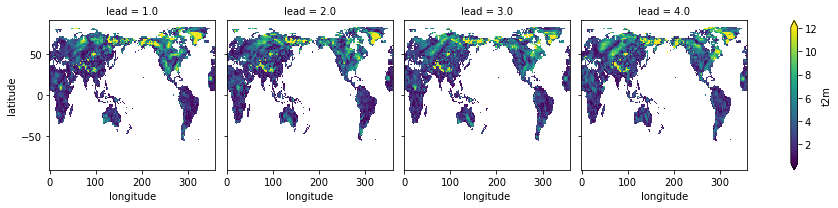

<IPython.core.display.Javascript object>

In [17]:
skill = fct.verify(**metric_kwargs)
skill[var].plot(col="lead", robust=True)

In [18]:
# still experimental, help appreciated https://github.com/pangeo-data/climpred/issues/605
# with climpred.set_options(seasonality="month"):
#    fct = fct.remove_bias(metric_kwargs["alignment"], cross_validate=False)

<IPython.core.display.Javascript object>

### biweekly aggregates

The `s2s-ai-challenge` requires biweekly target aggregates: https://s2s-ai-challenge.github.io/

There are two approaches possible for biweekly aggregates with `climpred`:

- create biweekly aggregate timeseries for observations and forecasts and then use `climpred`
- use daily leads and daily observations and `HindcastEnsemble.smooth()` to aggregate biweekly

#### biweekly aggregates before using `climpred`

##### forecast

In [19]:
from climpred.utils import convert_Timedelta_to_lead_units

forecast = convert_Timedelta_to_lead_units(
    forecast_climetlab.rename({"lead_time": "lead"})
)

<IPython.core.display.Javascript object>

In [20]:
# create 14D averages
forecast_w12 = forecast.sel(lead=range(1, 14)).mean(dim="lead")
forecast_w34 = forecast.sel(lead=range(14, 28)).mean(dim="lead")
forecast_w56 = forecast.sel(lead=range(28, 42)).mean(dim="lead")
forecast_biweekly = xr.concat([forecast_w12, forecast_w34, forecast_w56], dim="lead")
forecast_biweekly["lead"] = [
    1,
    14,
    28,
]  # lead represents first day of biweekly aggregate
forecast_biweekly["lead"].attrs["units"] = "days"
forecast_biweekly.coords

Coordinates:
  * realization    (realization) int64 0 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
  * forecast_time  (forecast_time) datetime64[ns] 2020-01-02 2020-02-06
  * latitude       (latitude) float64 90.0 88.5 87.0 85.5 ... -87.0 -88.5 -90.0
  * longitude      (longitude) float64 0.0 1.5 3.0 4.5 ... 355.5 357.0 358.5
  * lead           (lead) int64 1 14 28

<IPython.core.display.Javascript object>

##### observations

> here I use rolling 14D mean, and set the time index to the starting date, i.e. I get 14D averages for every previous time date

In [21]:
# 14D rolling mean
obs_biweekly = obs.rolling(time=14, center=False).mean()
obs_biweekly = obs_biweekly.isel(time=slice(13, None)).assign_coords(
    time=obs.time.isel(time=slice(None, -13))
)  # time represents first day of the biweekly aggregate

<IPython.core.display.Javascript object>

In [22]:
fct_biweekly = climpred.HindcastEnsemble(forecast_biweekly).add_observations(
    obs_biweekly
)

/Users/aaron.spring/Coding/climpred/climpred/checks.py:234: UserWarning: Did not find dimension "init", but renamed dimension forecast_time with CF-complying standard_name "forecast_reference_time" to init.
  warnings.warn(
/Users/aaron.spring/Coding/climpred/climpred/checks.py:234: UserWarning: Did not find dimension "member", but renamed dimension realization with CF-complying standard_name "realization" to member.
  warnings.warn(


<IPython.core.display.Javascript object>

In [23]:
obs_edges = (
    obs_biweekly.groupby("time.month")
    .quantile(q=[1 / 3, 2 / 3], dim="time", skipna=False)
    .rename({"quantile": "category_edge"})
)

<IPython.core.display.Javascript object>

In [24]:
model_edges = (
    forecast_biweekly.rename({"forecast_time": "init", "realization": "member"})
    .groupby("init.month")
    .quantile(q=[1 / 3, 2 / 3], dim=["init", "member"], skipna=False)
    .rename({"quantile": "category_edge"})
)

<IPython.core.display.Javascript object>

##### `rps`

In [25]:
rps_same_edges = fct_biweekly.verify(
    metric="rps",
    comparison="m2o",
    alignment="same_inits",
    dim=["member", "init"],
    category_edges=obs_edges,
)

<IPython.core.display.Javascript object>

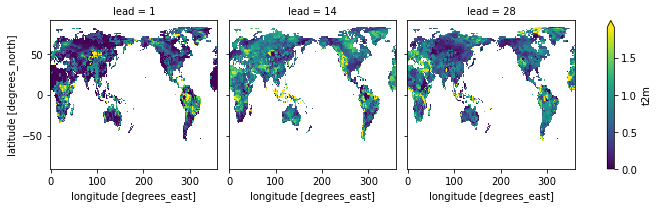

<IPython.core.display.Javascript object>

In [26]:
rps_same_edges.t2m.plot(col="lead", robust=True)

In [27]:
rps_different_edges = fct_biweekly.verify(
    metric="rps",
    comparison="m2o",
    alignment="same_inits",
    dim=["member", "init"],
    category_edges=(obs_edges, model_edges),
)

<IPython.core.display.Javascript object>

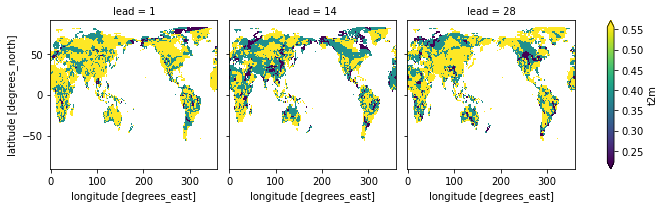

<IPython.core.display.Javascript object>

In [28]:
rps_different_edges.t2m.plot(col="lead", robust=True)

> Using the `model_edges` to categorize the forecasts and `obs_edges` to categorize the observations separately is an inherent bias correction and improves `rps`.

### biweekly aggregates with `smooth`

https://climpred.readthedocs.io/en/stable/api/climpred.classes.HindcastEnsemble.smooth.html#climpred.classes.HindcastEnsemble.smooth

In [29]:
fct = (
    climpred.HindcastEnsemble(forecast_climetlab.drop("valid_time"))
    .add_observations(obs)
    .compute()
)

/Users/aaron.spring/Coding/climpred/climpred/checks.py:234: UserWarning: Did not find dimension "init", but renamed dimension forecast_time with CF-complying standard_name "forecast_reference_time" to init.
  warnings.warn(
/Users/aaron.spring/Coding/climpred/climpred/checks.py:234: UserWarning: Did not find dimension "member", but renamed dimension realization with CF-complying standard_name "realization" to member.
  warnings.warn(
/Users/aaron.spring/Coding/climpred/climpred/checks.py:234: UserWarning: Did not find dimension "lead", but renamed dimension lead_time with CF-complying standard_name "forecast_period" to lead.
  warnings.warn(


<IPython.core.display.Javascript object>

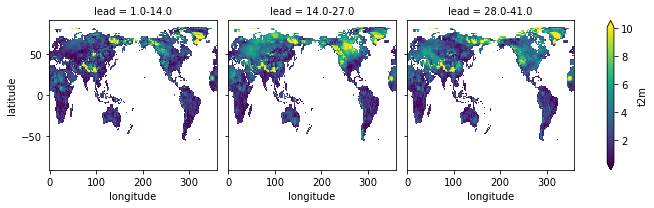

<IPython.core.display.Javascript object>

In [30]:
# first smooth and then subselect leads
fct.smooth(dict(lead=14), how="mean").verify(
    metric="rmse", comparison="e2o", dim="init", alignment="maximize"
).sel(lead=["1.0-14.0", "14.0-27.0", "28.0-41.0"]).t2m.plot(col="lead", robust=True)

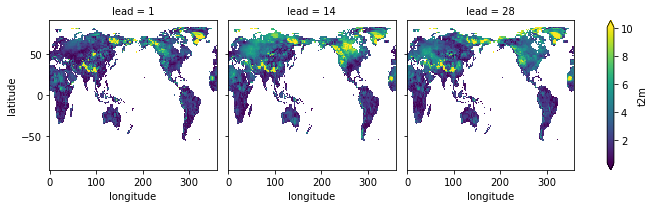

<IPython.core.display.Javascript object>

In [31]:
fct_biweekly.verify(
    metric="rmse", comparison="e2o", alignment="maximize", dim=["init"],
).t2m.plot(col="lead", robust=True)